In [82]:
import re
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from wordcloud import WordCloud
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [83]:
train_df = pd.read_csv("C://Users/Sordhiq/Desktop/EDSA/Classification_Sprint/Predict/data/train.csv")
test_df = pd.read_csv("C://Users/Sordhiq/Desktop/EDSA/Classification_Sprint/Predict/data/test.csv")
sample_df = pd.read_csv("C://Users/Sordhiq/Desktop/EDSA/Classification_Sprint/Predict/data/sample_submission.csv")

In [3]:
train_df.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [4]:
train_df.shape

(15819, 3)

In [5]:
train_df['sentiment'].unique()

array([ 1,  2,  0, -1], dtype=int64)

In [6]:
unique = train_df['message'].nunique()

print ('There are {} unique words in the Message corpus.'.format(unique))

There are 14229 unique words in the Message corpus.


2 = News #The tweet leads to factual news about climate change

1 = Pro #The tweet supports the believe of man-induced climate change

0 = Neutral #The tweet neither supports nor refutes the belief of man-made climate change

-1 = Anti #The tweet does not believe in mad-induced climate change variable definitions

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


### Visualizing for proportion of respondents

Text(0.5, 1.0, 'Plot of Sentiments with magnitude')

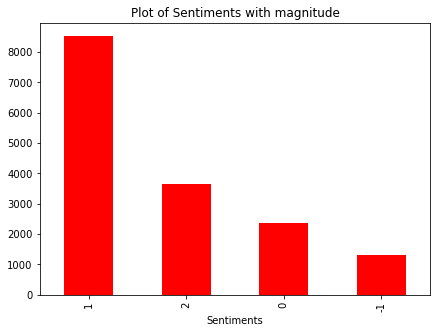

In [8]:
train_df['sentiment'].value_counts().plot(kind='bar', color='red', figsize=(7, 5))
plt.xlabel('Sentiments')
plt.title('Plot of Sentiments with magnitude')

### WordCloud of popoular terms

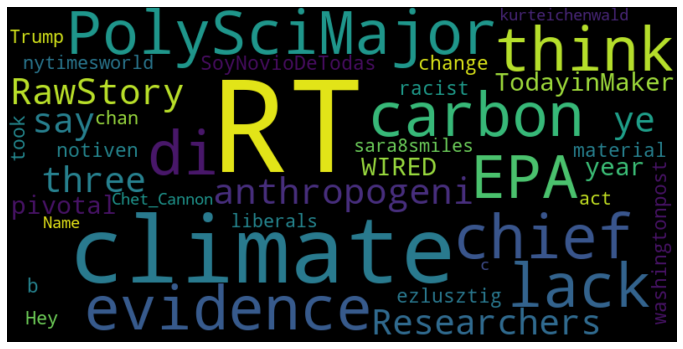

In [9]:
wordcloud = WordCloud()

WCloud = WordCloud(width=800, height=400, max_words=40).generate(str(train_df['message']))
plt.figure(figsize=(12, 10))
plt.imshow(WCloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Splitting the tweets into their respective sentences

In [10]:
sentence = []
for i, row in train_df.iterrows():
    for j in row['message'].split(':'):
        sentence.append([row['sentiment'], j])
sentence = pd.DataFrame(sentence, columns=['sentiment', 'message'])

In [11]:
sentence

,sentiment,message
0,1,PolySciMajor EPA chief doesn't think carbon di...
1,1,//t.co/yeLvcEFXkC via @mashable
2,1,It's not like we lack evidence of anthropogeni...
3,2,RT @RawStory
4,2,Researchers say we have three years to act on...
...,...,...
38366,-1,RT @sara8smiles
38367,-1,Hey liberals the climate change crap is a hoa...
38368,0,RT @Chet_Cannon
38369,0,.@kurteichenwald's 'climate change equation' ...


### Visualizing the splitted tweets...

Text(0.5, 1.0, 'Plot of Sentiments with Magnitude')

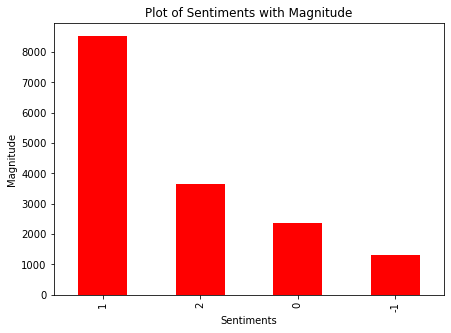

In [12]:
train_df['sentiment'].value_counts().plot(kind='bar', color='red', figsize=(7, 5))

plt.xlabel('Sentiments')
plt.ylabel('Magnitude')
plt.title('Plot of Sentiments with Magnitude')

In [13]:
figures = sentence['sentiment'].unique()
letters = ['Believe','News', 'Neutral', 'Disbelieve']

In [14]:
tables = pd.DataFrame(zip(figures, letters), columns=['Number', 'Sentiment'])
print(tables['Sentiment'])

0       Believe
1          News
2       Neutral
3    Disbelieve
Name: Sentiment, dtype: object


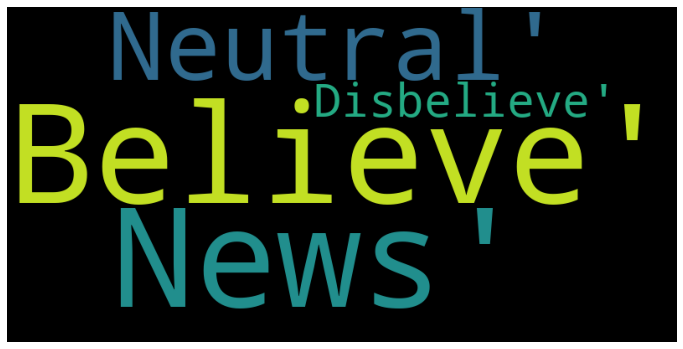

In [15]:
WCloud = WordCloud(width=800, height=400, max_words=50).generate(str(tables['Sentiment'].values))
plt.figure(figsize=(12, 10))
plt.imshow(WCloud)
plt.axis('off')
plt.show()

### Next, we replace site urls with prefered text

In [16]:
urls =  r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
rep_urls = r'replaced urls'

sentence['message'] = sentence['message'].replace(value=rep_urls, to_replace=urls, regex=True)

In [17]:
sentence['message'].head()

0    PolySciMajor EPA chief doesn't think carbon di...
1                      //t.co/yeLvcEFXkC via @mashable
2    It's not like we lack evidence of anthropogeni...
3                                         RT @RawStory
4     Researchers say we have three years to act on...
Name: message, dtype: object

### And converts the text to all lower case 

In [18]:
sentence['message'] = sentence['message'].str.lower()

In [19]:
sentence['message']

0        polyscimajor epa chief doesn't think carbon di...
1                          //t.co/yelvcefxkc via @mashable
2        it's not like we lack evidence of anthropogeni...
3                                             rt @rawstory
4         researchers say we have three years to act on...
                               ...                        
38366                                      rt @sara8smiles
38367     hey liberals the climate change crap is a hoa...
38368                                      rt @chet_cannon
38369     .@kurteichenwald's 'climate change equation' ...
38370                                    //t.co/lp7uufcxdq
Name: message, Length: 38371, dtype: object

### Next, punctuations are removed to further clean the dataset

In [20]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [21]:
def remove_puncs (message):
    return ''.join(i for i in message if i not in string.punctuation)

In [22]:
sentence['message'] = sentence['message'].apply(remove_puncs)

In [23]:
sentence['message'].iloc[22313]

' firms must come clean on exposure to climate change risks https'

### Next, we `Tokenize` the cleaned `sentence` into tokens

In [24]:
from nltk.tokenize import word_tokenize, TreebankWordTokenizer

In [25]:
tokeniser = TreebankWordTokenizer()
sentence['tokens'] = sentence['message'].apply(tokeniser.tokenize)

In [26]:
sentence['tokens'].iloc[3425]

['shes',
 'thinking',
 'about',
 'how',
 'shes',
 'going',
 'to',
 'die',
 'because',
 'your',
 'husband',
 'doesnt',
 'believe',
 'in',
 'climate',
 'change',
 'https']

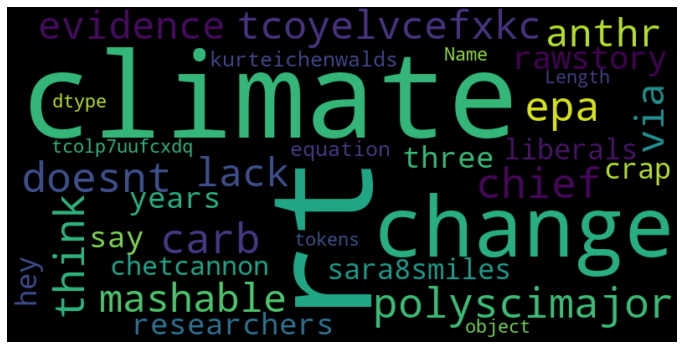

<Figure size 432x288 with 0 Axes>

In [27]:
WCloud = WordCloud(width=800, height=400, max_words=50).generate(str(sentence['tokens']))
plt.figure(figsize=(12, 10))
plt.imshow(WCloud, interpolation='bilinear')
plt.axis('off')
plt.show()
plt.savefig('wordclod')

### And `Stemmatize` back to the root words

In [28]:
from nltk import SnowballStemmer

In [29]:
stemmer = SnowballStemmer('english')

In [30]:
def mbti_stemmer(words, stemmer):
    return [stemmer.stem(word) for word in words]

In [31]:
sentence['stem'] = sentence['tokens'].apply(mbti_stemmer, args=(stemmer, ))

In [32]:
for i, t in enumerate(sentence.iloc[12402]['tokens']):    
    print ('{:20s} ==> {:10s}'.format(t, sentence.iloc[12402]['stem'][i]))

energy               ==> energi    
department           ==> depart    
tells                ==> tell      
staff                ==> staff     
to                   ==> to        
stop                 ==> stop      
using                ==> use       
phrase               ==> phrase    
climate              ==> climat    
change               ==> chang     
ecowatch             ==> ecowatch  
https                ==> https     


In [33]:
from nltk.corpus import stopwords

In [34]:
stopwords_list = stopwords.words('english')

In [35]:
def remove_stop_words(words):
    return ([text for text in words if text not in stopwords.words('english') ])

In [36]:
%%time 

sentence['stem'] = sentence['tokens'].apply(remove_stop_words) #Timey

CPU times: total: 2min 15s
Wall time: 2min 25s


### Now, we attempt extracting features from the text using the `CountVectorizer` class

In [37]:
from sklearn.feature_extraction.text import CountVectorizer

In [38]:
vect = CountVectorizer(stop_words='english', ngram_range=(1, 3), analyzer='word', max_df= 5, min_df=2, max_features=500)
X = vect.fit_transform(sentence['message']).toarray()

In [39]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

### Afterwards, we standardize the features

In [40]:
X_scaled = StandardScaler()

In [41]:
X = X_scaled.fit_transform(X)
X

array([[-0.01141594, -0.01141594, -0.01141594, ..., -0.01141594,
        -0.01141594, -0.01141594],
       [-0.01141594, -0.01141594, -0.01141594, ..., -0.01141594,
        -0.01141594, -0.01141594],
       [-0.01141594, -0.01141594, -0.01141594, ..., -0.01141594,
        -0.01141594, -0.01141594],
       ...,
       [-0.01141594, -0.01141594, -0.01141594, ..., -0.01141594,
        -0.01141594, -0.01141594],
       [-0.01141594, -0.01141594, -0.01141594, ..., -0.01141594,
        -0.01141594, -0.01141594],
       [-0.01141594, -0.01141594, -0.01141594, ..., -0.01141594,
        -0.01141594, -0.01141594]])

### Defining the `Target` variable

In [42]:
y = sentence['sentiment'] 

In [43]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.10, random_state=50)

In [44]:
logc = LogisticRegression(random_state=50, max_iter=10, C=1, n_jobs=2, verbose=False)
logc

LogisticRegression(C=1, max_iter=10, n_jobs=2, random_state=50, verbose=False)

In [45]:
logc.fit(X_train, y_train)

LogisticRegression(C=1, max_iter=10, n_jobs=2, random_state=50, verbose=False)

In [46]:
pred = logc.predict(X_val)
pred

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [47]:
svc = SVC(C=1, gamma='scale', kernel='rbf')

In [48]:
%%time

svc.fit(X_train, y_train)

CPU times: total: 9min 41s
Wall time: 10min 16s


SVC(C=1)

In [49]:
nbaye = GaussianNB()

In [50]:
%%time

nbaye.fit(X_train, y_train)

CPU times: total: 469 ms
Wall time: 495 ms


GaussianNB()

In [51]:
randf = RandomForestClassifier()

In [52]:
%%time

randf.fit(X_train, y_train)

CPU times: total: 4min
Wall time: 4min 13s


RandomForestClassifier()

In [56]:
def scoring (model):
    pred = model.predict(X_val)
    conf_m = classification_report(y_val, model.predict(X_val))
    return print(conf_m)

In [57]:
scoring (svc)

              precision    recall  f1-score   support

          -1       0.45      0.02      0.04       251
           0       0.50      0.02      0.03       445
           1       0.54      0.99      0.70      2042
           2       0.65      0.02      0.04      1100

    accuracy                           0.54      3838
   macro avg       0.53      0.26      0.20      3838
weighted avg       0.56      0.54      0.39      3838



In [58]:
scoring (randf)

              precision    recall  f1-score   support

          -1       0.45      0.02      0.04       251
           0       0.44      0.02      0.03       445
           1       0.54      0.99      0.70      2042
           2       0.61      0.02      0.05      1100

    accuracy                           0.54      3838
   macro avg       0.51      0.26      0.20      3838
weighted avg       0.54      0.54      0.39      3838



In [59]:
scoring (nbaye)

              precision    recall  f1-score   support

          -1       0.07      0.96      0.12       251
           0       0.24      0.02      0.04       445
           1       0.83      0.02      0.04      2042
           2       0.53      0.03      0.05      1100

    accuracy                           0.08      3838
   macro avg       0.42      0.26      0.06      3838
weighted avg       0.62      0.08      0.05      3838



In [60]:
scoring (logc)

              precision    recall  f1-score   support

          -1       0.31      0.02      0.04       251
           0       0.42      0.02      0.03       445
           1       0.54      0.99      0.70      2042
           2       0.58      0.03      0.05      1100

    accuracy                           0.54      3838
   macro avg       0.46      0.26      0.20      3838
weighted avg       0.52      0.54      0.39      3838



In [61]:
booc = AdaBoostClassifier(n_estimators=1, random_state=50)

In [62]:
booc.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=1, random_state=50)

In [63]:
scoring(booc)

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       251
           0       0.00      0.00      0.00       445
           1       0.53      1.00      0.69      2042
           2       0.00      0.00      0.00      1100

    accuracy                           0.53      3838
   macro avg       0.13      0.25      0.17      3838
weighted avg       0.28      0.53      0.37      3838



In [64]:
from sklearn.neighbors import KNeighborsClassifier

In [65]:
knc = KNeighborsClassifier()

In [66]:
knc.fit(X_train, y_train)

KNeighborsClassifier()

In [67]:
scoring (knc)

              precision    recall  f1-score   support

          -1       0.32      0.02      0.04       251
           0       0.35      0.02      0.03       445
           1       0.54      0.99      0.70      2042
           2       0.72      0.02      0.04      1100

    accuracy                           0.54      3838
   macro avg       0.48      0.26      0.20      3838
weighted avg       0.55      0.54      0.39      3838



### Now we save the model for reuse

In [68]:
import pickle

In [69]:
with open ('saved_model', 'wb') as f:
    pickle.dump(logc, f)

In [70]:
with open ('saved_model', 'rb') as f:
   model = pickle.load(f)

# Test Data

### Now we replicate all transformations to the `Train` data, on the `Test` data

In [84]:
test_df['message'] = [i.split('#') for i in test_df['message']]
sentences = pd.DataFrame(test_df['message'])


urls = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@ã¢â¬¢.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
new_url = r'replaced_url'
sentences['message'] = sentences['message'].replace(value=urls, to_replace= new_url, regex=True)


sentences['message'] = sentences['message'].apply(remove_puncs)


tokeniser = TreebankWordTokenizer()
sentences['tokens'] = sentences['message'].apply(tokeniser.tokenize)


sentences['stem'] = sentences['tokens'].apply(mbti_stemmer, args=(stemmer, ))

sentences['stem'] = sentences['stem'].apply(remove_stop_words) #Timey


count_vect = CountVectorizer(stop_words='english', ngram_range=(1, 2), analyzer='word', max_df= 5, min_df=2, max_features=500)
y_tests = count_vect.fit_transform(sentences['message']).toarray()


y_test_scaled = StandardScaler()
y_test = y_test_scaled.fit_transform(y_tests)

In [85]:
y_test = logc.predict(y_tests)
y_test

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [86]:
submission = pd.DataFrame({'tweetid':sample_df['tweetid'], 'sentiment':y_test})
submission

,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,1
4,872928,1
...,...,...
10541,895714,1
10542,875167,1
10543,78329,1
10544,867455,1


In [87]:
submission = submission.to_csv('classi_submission.csv', index=False)
submission

### Finally, we save our model for reusability

In [76]:
import pickle

In [77]:
with open ('classi_model', 'wb') as f:
    pickle.dump(y_test, f)

In [78]:
with open ('classi_model', 'rb') as f:
    predictions = pickle.load(f)

ha😉❤